**Implementation using Google's GPU: https://colab.research.google.com/drive/1xMlIDzx0w_TlXFeMbD1zH0ZdPmlkboIG?usp=sharing**

In [23]:
%pip install numpy keras matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

**Data Manipulation:**

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255
x_test = np.reshape(x_test, (x_test.shape[0], -1)) / 255

# m: Number of train images
# n: Number of pixels
# m_t: Number of test images
m,n = x_train.shape
m_t = x_test.shape[0]

def one_hot_encoding(size, Y):
    ny = np.zeros(size)
    for i in range(size[0]):
        ny[i,Y[i]] = 1
    return ny

y_train = one_hot_encoding((m,10), y_train)
y_test = one_hot_encoding((m_t,10), y_test)

W = np.random.normal(0, 1, (n, 10))
B = np.zeros((1, 10))

**Model Functions:**

In [26]:
def sigmoid(Z):
    Z = np.clip(Z, -700, 700)
    return (1 + np.exp(-1 * Z)) ** (-1)

def predict_model(X, W, B):
    Z = np.matmul(X,W) + B
    Z = sigmoid(Z)
    idx = (Z >= 0.5)
    F = np.zeros(Z.shape)
    F[idx] = 1
    return F,Z

def gradients(X, Y, F, lambda_):
    common_factor = F - Y
    GW = np.matmul(X.T,common_factor) + lambda_ * W / m
    GB = np.matmul(np.ones((1,m)),common_factor) / m
    return GW,GB

def comp_loss(Y, Z, lambda_):
    epsilon = 1e-15
    Z = np.clip(Z, epsilon, 1 - epsilon)
    cross_entropy_loss = -1 * np.sum(Y * np.log(Z) + (1 - Y) * np.log(1 - Z), axis=0) / (2 * m)
    l2_loss = lambda_ * np.sum(W ** 2, axis=0) / (2 * m)
    return cross_entropy_loss + l2_loss

def train_model(X, Y, W, B, alpha=0.05, iterations=100, lambda_=0.1):
    loss_hist = []
    for i in tqdm(range(iterations)):
        F,Z = predict_model(X,W,B)
        GW,GB = gradients(X,Y,F,lambda_)
        W -= alpha*GW
        B -= alpha*GB
        loss_hist.append(comp_loss(Y,Z,lambda_))
        alpha *= 0.995
    loss_hist = np.array(loss_hist)
    return B,W,F,loss_hist

def test_model(X, Y, W, B):
    F,Z = predict_model(X,W,B)
    f1, precision = f1_score(Y,F)
    return F, f1, precision

def f1_score(Y, F):
    Y = Y.astype(int)
    F = F.astype(int)
    tp = np.sum((Y == 1) & (F == 1))
    fp = np.sum((Y == 0) & (F == 1))
    fn = np.sum((Y == 1) & (F == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1, precision

**Model Training:**

In [27]:
iterations = 5000
lambda_ = 0.1
alpha = 5e-5
B,W,F,loss_hist = train_model(x_train, y_train, W, B, iterations=iterations, lambda_=lambda_, alpha=alpha)

100%|██████████| 5000/5000 [09:53<00:00,  8.42it/s]


**Training Statistics:**

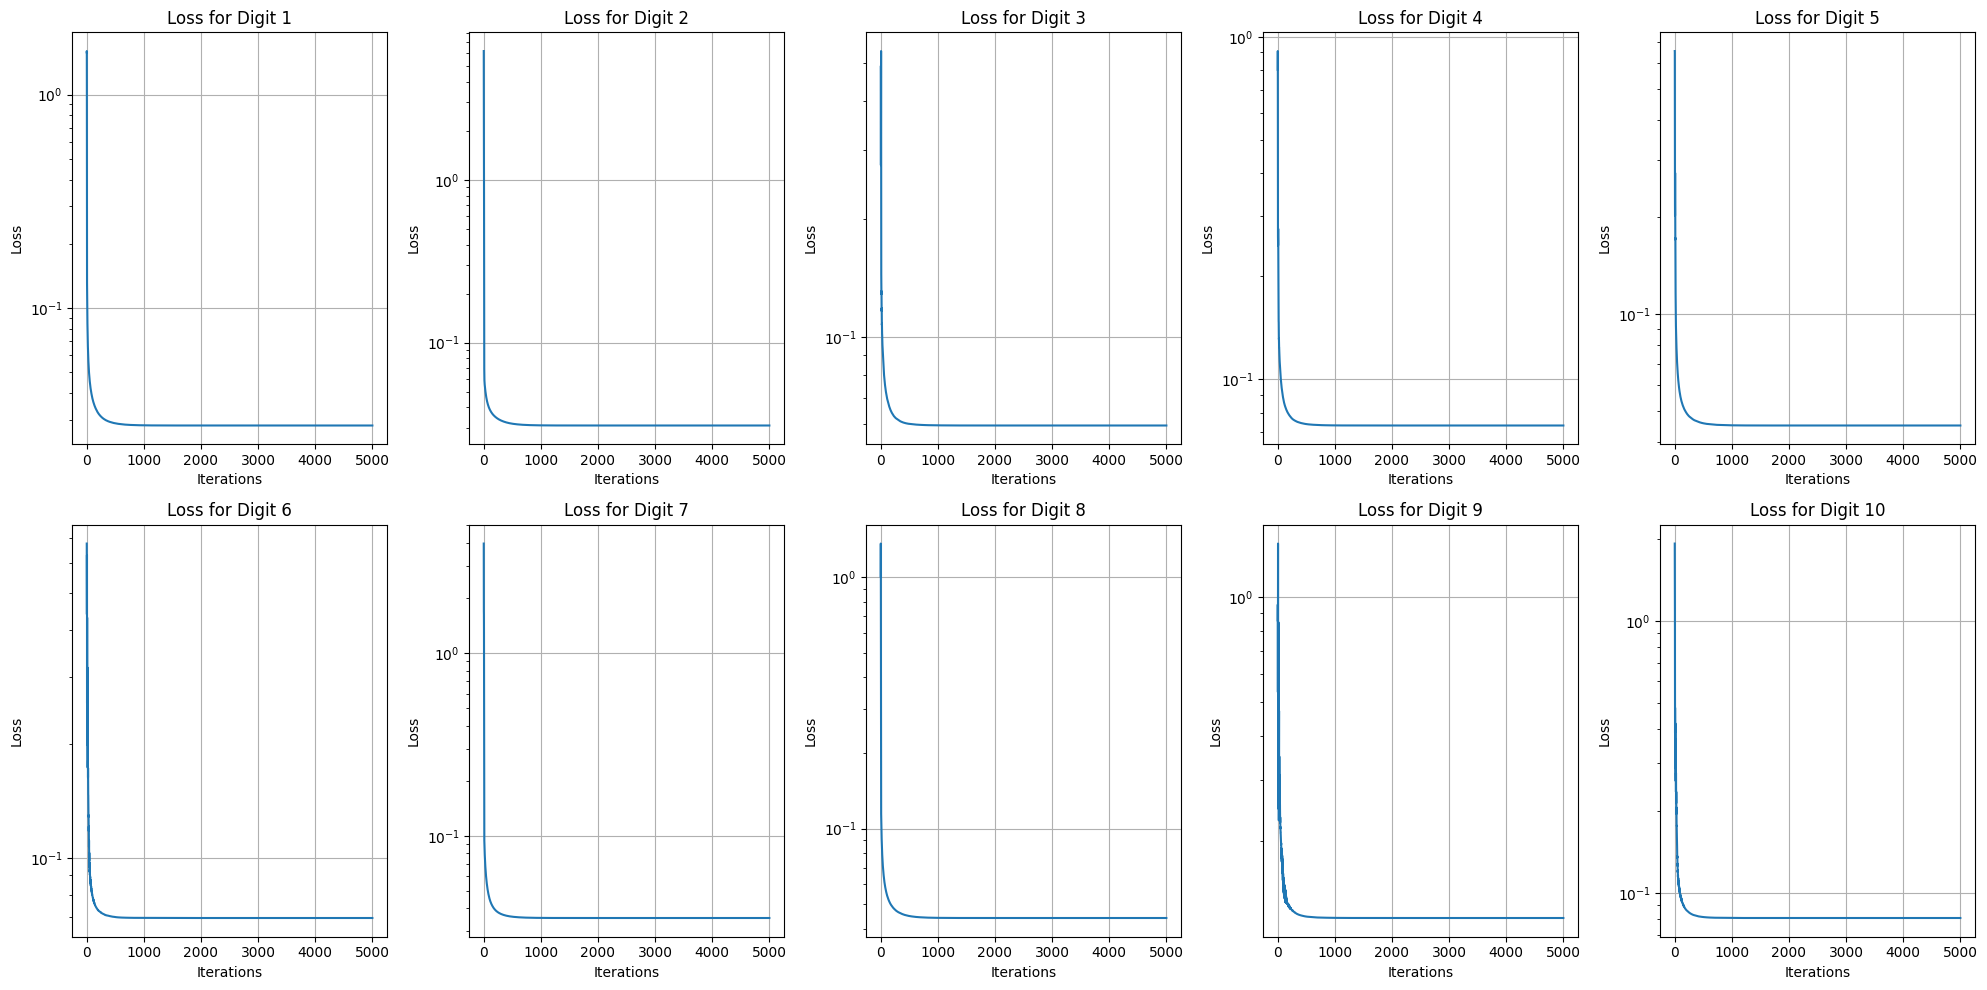

F1 Score: 0.8109924063463001
Precision: 0.7957779239320489


In [28]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i in range(10):
    axes[i].plot(range(1, iterations + 1), loss_hist[:, i])
    axes[i].set_title(f'Loss for Digit {i + 1}')
    axes[i].set_xlabel('Iterations')
    axes[i].set_ylabel('Loss')
    axes[i].set_yscale('log')
    axes[i].grid()

plt.tight_layout()
plt.show()

f1, precision = f1_score(y_train,F)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")

**Testing Statistics:**

In [29]:
F_test,f1_test,precision_test = test_model(x_test, y_test, W, B)
print(f"F1 Score: {f1_test}")
print(f"Precision: {precision_test}")

F1 Score: 0.8134780907668232
Precision: 0.7960375191424196
